In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
L = 1.0
n = 10
x0 = -L
y0 = -L

In [3]:
h = (2.0 * L) / (n - 1)

In [4]:
#def sourcef(x, y):
#    return 2 * np.pi * np.pi * np.sin(np.pi * x) * np.sin(np.pi * y)
#def sourcef(x, y):
#    return 2 * np.pi * np.pi * np.cos(np.pi * x) * np.cos(np.pi * y)
def sourcef(x, y):
    return 1

In [5]:
#def boundary(x, y):
#    return np.sin(np.pi * x) * np.sin(np.pi * y)
#def boundary(x, y):
#    return np.cos(np.pi * x) * np.cos(np.pi * y)
def boundary(x, y):
    return 0

In [6]:
def boundaryIdx(n):
    idx = list(range(n))
    for i in range(n - 2):
        idx.append((i + 1) * n)
        idx.append((i + 2) * n - 1)
    idx.extend(list(range(n ** 2 - n, n ** 2)))
    return idx

In [7]:
def gDofIdx2Pnt(x0, y0, n, h, di):
    if di > n**2 - 1:
        return (-999, -999)
    x = x0 + di % n * h
    y = y0 + di // n * h
    return x, y

In [8]:
def gEleIdx2PntIdx(n, ei):
    if ei > (n - 1)**2 - 1:
        return(-1, -1, -1, -1)
    LB = ei + ei // (n - 1)
    return [LB, LB + 1, LB + n + 1, LB + n]

In [9]:
def gEleIdx2Pnt(n, ei):
    gdi = gEleIdx2PntIdx(n, ei)
    pnts = np.zeros((4, 2), dtype = float)
    k = 0
    for gi in gdi:
        pnts[k][0], pnts[k][1] = gDofIdx2Pnt(x0, y0, n, h, gi)
        k = k + 1    
    return pnts

In [10]:
def Chi(xi, eta):
    Chi1 = (xi - 1.0) * (eta - 1.0) / 4.0
    Chi2 = -(xi + 1.0) * (eta - 1.0) / 4.0
    Chi3 = (xi + 1.0) * (eta + 1.0) / 4.0
    Chi4 = -(xi - 1.0) * (eta + 1.0) / 4.0
    return [Chi1, Chi2, Chi3, Chi4]

In [11]:
def gradientChi(xi, eta):
    Chi1xi = (eta - 1.0) / 4.0
    Chi1eta = (xi - 1.0) / 4.0
    Chi2xi = (1.0 - eta) / 4.0
    Chi2eta = -(xi + 1.0) / 4.0
    Chi3xi = (eta + 1.0) / 4.0
    Chi3eta = (xi + 1.0) / 4.0
    Chi4xi = -(eta + 1.0) / 4.0
    Chi4eta = -(xi - 1.0) / 4.0
    return np.array([[Chi1xi, Chi2xi, Chi3xi, Chi4xi], [Chi1eta, Chi2eta, Chi3eta, Chi4eta]]) 

In [12]:
def Jacobi(n, ei, xi, eta):
    return np.dot(gradientChi(xi, eta), gEleIdx2Pnt(n, ei))

In [13]:
GaussPnt = [[-0.577350269189626, -0.577350269189626, 1.0],
            [0.577350269189626, -0.577350269189626, 1.0],
            [0.577350269189626, 0.577350269189626, 1.0],
            [-0.577350269189626, 0.577350269189626, 1.0]]

In [14]:
nElm = (n - 1) ** 2
lA = np.zeros((nElm, 4, 4), dtype = float)
for ei in range(nElm):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                xi = GaussPnt[k][0]
                eta = GaussPnt[k][1]
                w = GaussPnt[k][2]
                J = Jacobi(n, ei, xi, eta)
                invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / np.linalg.det(J)
                lA[ei][i][j] += w * np.linalg.det(J) * np.dot(np.dot(gradientChi(xi, eta)[:, i], invJ.T), np.dot(gradientChi(xi, eta)[:, j], invJ.T))                                            

In [15]:
lf = np.zeros((nElm, 4), dtype = float)
for ei in range(nElm):
    for i in range(4):
        for k in range(4):
            xi = GaussPnt[k][0]
            eta = GaussPnt[k][1]
            w = GaussPnt[k][2]
            J = Jacobi(n, ei, xi, eta)
            x = (xi + 1) / 2 * h + gEleIdx2Pnt(n, ei)[0][0]
            y = (eta + 1) / 2 * h + gEleIdx2Pnt(n, ei)[0][1]
            lf[ei][i] += w * sourcef(x,y) * Chi(xi, eta)[i] * np.linalg.det(J)

In [16]:
nDof = n ** 2
A = np.zeros((nDof, nDof), dtype = float)
f = np.zeros(nDof, dtype = float)
for ei in range(nElm):
    for j in range(4):
        for i in range(4):
            A[gEleIdx2PntIdx(n, ei)[i], gEleIdx2PntIdx(n, ei)[j]] += lA[ei, i, j]
        f[gEleIdx2PntIdx(n, ei)[j]] += lf[ei, j]

In [17]:
bIdx = boundaryIdx(n)
for i in bIdx:
    pnt = gDofIdx2Pnt(x0, y0, n, h, i)
    value = boundary(pnt[0], pnt[1])
    f = f - A[:, i] * value
    A[i, :] = 0
    A[:, i] = 0
    A[i, i] = 1
    f[i] = value

In [18]:
u = np.linalg.solve(A, f)

In [19]:
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
f

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938272,
       0.04938272, 0.04938272, 0.04938272, 0.04938272, 0.        ,
       0.        , 0.04938272, 0.04938272, 0.04938272, 0.04938

In [21]:
u

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06296484, 0.09786006, 0.11778537, 0.1269456 ,
       0.1269456 , 0.11778537, 0.09786006, 0.06296484, 0.        ,
       0.        , 0.09786006, 0.15985045, 0.19627162, 0.21320704,
       0.21320704, 0.19627162, 0.15985045, 0.09786006, 0.        ,
       0.        , 0.11778537, 0.19627162, 0.24385649, 0.26624823,
       0.26624823, 0.24385649, 0.19627162, 0.11778537, 0.        ,
       0.        , 0.1269456 , 0.21320704, 0.26624823, 0.29139951,
       0.29139951, 0.26624823, 0.21320704, 0.1269456 , 0.        ,
       0.        , 0.1269456 , 0.21320704, 0.26624823, 0.29139951,
       0.29139951, 0.26624823, 0.21320704, 0.1269456 , 0.        ,
       0.        , 0.11778537, 0.19627162, 0.24385649, 0.26624823,
       0.26624823, 0.24385649, 0.19627162, 0.11778537, 0.        ,
       0.        , 0.09786006, 0.15985045, 0.19627162, 0.21320

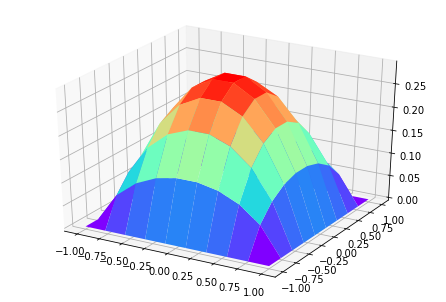

In [22]:
figure = plt.figure()
ax = Axes3D(figure)
X = np.arange(x0, x0 + 2 * L + h / 2, h)
Y = np.arange(y0, y0 + 2 * L + h / 2, h)
X, Y = np.meshgrid(X, Y)
Z = u.reshape(n,n)
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'rainbow')
plt.show()